In [ ]:
from google.colab import drive
import os
drive.mount('/content/drive')
DRIVE_PATH = "/content/drive/My Drive/science4cast"

Mounted at /content/drive


In [ ]:
import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
import pandas as pd
import pickle
from scipy import sparse, stats
from datetime import date, timedelta

In [ ]:
day_origin = date(1990,1,1)
NUM_OF_VERTICES = 64719

def filter_by_year(df, before=None, after=None):
  if before is not None:
    day_max = date(before,12,31)
  else:
    day_max = date(2021,12,31)
  
  if after is not None:
    day_min = date(after,1,1)
  else:
    day_min = day_origin
  
  return df[df['timestamp'].between((day_min - day_origin).days, (day_max - day_origin).days)]

def map_concepts(df):
  df['concept1'] = concepts.loc[df['node1']].values
  df['concept2'] = concepts.loc[df['node2']].values

  return df

def day_to_date(day):
  return day_origin + timedelta(days=day)

def get_sparse_from_edges(edges):
    adj = sparse.csr_matrix(
        (np.ones(2*len(edges)), 
        (
            np.hstack((edges['node1'], edges['node2'])),
            np.hstack((edges['node2'], edges['node1']))
        )), 
        shape = (NUM_OF_VERTICES,NUM_OF_VERTICES),
        dtype = np.uint16
    )

    adj.setdiag(0) 
    adj.eliminate_zeros()
    
    return adj

In [ ]:
data_source = os.path.join(DRIVE_PATH, '20220203',  'SemanticGraph_delta_1_cutoff_0_minedge_1.pkl')
with open(data_source, "rb" ) as pkl_file:
  full_dynamic_graph_sparse, unconnected_vertex_pairs, unconnected_vertex_pairs_solution, year_start, years_delta, vertex_degree_cutoff, min_edges = pickle.load(pkl_file)

In [ ]:
edges = pd.DataFrame(full_dynamic_graph_sparse, columns=['node1', 'node2', 'timestamp'], dtype='float')
print('total of', len(edges), 'edges')
edges.head()

total of 17892352 edges


,node1,node2,timestamp
0,32126.0,32203.0,1460.0
1,32126.0,32378.0,1460.0
2,32126.0,32546.0,1460.0
3,32126.0,44706.0,1460.0
4,32126.0,48563.0,1460.0


In [ ]:
yrs = range(1993, 2020)
day_to_date(edges["timestamp"].min()), day_to_date(edges["timestamp"].max())

(datetime.date(1993, 12, 31), datetime.date(2019, 12, 30))

In [ ]:
concepts = pd.read_csv(os.path.join(DRIVE_PATH, '20220203', 'full_concepts_new.txt'), header=None, names=['concept'])
NUM_OF_VERTICES = len(concepts)
print('NUM_OF_VERTICES:', NUM_OF_VERTICES)
concepts.head()

NUM_OF_VERTICES: 64719


,concept
0,deep neural network
1,convolutional neural network
2,generative adversarial network
3,recurrent neural network
4,real world application


## Node degree distribution

/usr/local/lib/python3.7/dist-packages/scipy/sparse/_index.py:126: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


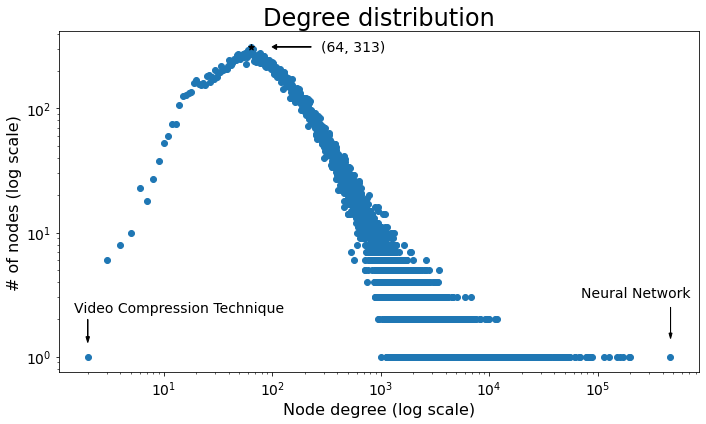

In [ ]:
yy = 2019

edges_small = filter_by_year(edges, before=yy)
degree_sequence = np.array(get_sparse_from_edges(edges_small).sum(axis=0)).flatten()

hist, bin_edges = np.histogram(degree_sequence, bins=np.arange(degree_sequence.min(), degree_sequence.max()+1))
bin_edges = bin_edges[1:-1]
hist = hist[1:]
bin_edges = bin_edges[hist != 0]
hist = hist[hist != 0]
plt.figure(figsize=(10, 6))
plt.scatter(bin_edges, hist)
plt.loglog()
plt.xlabel('Node degree (log scale)', fontsize=16)
plt.ylabel('# of nodes (log scale)', fontsize=16)
plt.title('Degree distribution', fontsize=24)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)

plt.scatter(64, 313, c='k', marker='*')

plt.text(280, 290, '(64, 313)', fontsize=14)
plt.text(70000, 3, 'Neural Network', fontsize=14)
plt.text(1.5, 2.3, 'Video Compression Technique', fontsize=14)

plt.arrow(470000, 2.5, 0, -1.1, head_width=30000, head_length=0.15,length_includes_head=True,edgecolor='k', facecolor='k')
plt.arrow(230, 313, -130, 0, head_width=30, head_length=10, length_includes_head=True, edgecolor='k', facecolor='k')
plt.arrow(2, 2, 0, -0.7, head_width=0.15, head_length=0.15, length_includes_head=True, edgecolor='k', facecolor='k')

plt.tight_layout()
plt.savefig(os.path.join(DRIVE_PATH, '20220203', 'degree_hist', str(yy)+'.pdf'), dpi=300, pad_inches=0)
plt.show()

In [ ]:
pd.DataFrame(data={'xvalue': bin_edges, 'counts': hist}).to_csv(os.path.join(DRIVE_PATH,'degseq.csv'), index=False)

print('total', sum(degree_sequence)/2, 'edges')
print()
print('max degree', degree_sequence.max(), concepts.loc[degree_sequence == degree_sequence.max()].values.flatten())
print()
print(np.flip(sorted(degree_sequence)[-10:]))
idx = np.flip(degree_sequence.argsort()[-10:])
print(idx)
print(concepts.loc[idx])
print()
print('min degree', degree_sequence.min(), degree_sequence[degree_sequence>0].min(),
      concepts.loc[degree_sequence[degree_sequence>0].argmin()])
print()
print('mean degree', degree_sequence.mean(), degree_sequence[degree_sequence>0].mean())
print('mode degree', stats.mode(degree_sequence[degree_sequence>0]))


total 17892352.0 edges

max degree 466319 ['neural network']

[466319 198050 195345 169555 159403 150227 127642 115334  89267  84956]
[31762 31764 31763     1 31794 31761     0 31870 31909 31961]
                            concept
31762                neural network
31764                 deep learning
31763              machine learning
1      convolutional neural network
31794                    real world
31761           experimental result
0               deep neural network
31870                   large scale
31909                high dimension
31961              high dimensional

min degree 0 2 concept    video compression technique
Name: 29459, dtype: object

mean degree 552.9242417219054 563.7872447693471
mode degree ModeResult(mode=array([64], dtype=uint64), count=array([313]))


/usr/local/lib/python3.7/dist-packages/scipy/sparse/_index.py:126: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


total 21.0 edges
max degree 6 ['dynamic environment' 'run time' 'mobile robot' 'autonomous agent'
 'agent action' 'agent control' 'might arise']
min degree 0
mean degree 0.0006489593473323136


/usr/local/lib/python3.7/dist-packages/scipy/sparse/_index.py:126: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


total 1058.0 edges
max degree 49 ['decision tree']
min degree 0
mean degree 0.032695189975123225


/usr/local/lib/python3.7/dist-packages/scipy/sparse/_index.py:126: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


total 3344.0 edges
max degree 68 ['decision tree']
min degree 0
mean degree 0.10333905035615507


/usr/local/lib/python3.7/dist-packages/scipy/sparse/_index.py:126: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


total 5287.0 edges
max degree 114 ['machine learning']
min degree 0
mean degree 0.1633832413974258


/usr/local/lib/python3.7/dist-packages/scipy/sparse/_index.py:126: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


total 6837.0 edges
max degree 127 ['machine learning']
min degree 0
mean degree 0.2112826217957632


/usr/local/lib/python3.7/dist-packages/scipy/sparse/_index.py:126: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


total 9795.0 edges
max degree 204 ['machine learning']
min degree 0
mean degree 0.3026931812914291


/usr/local/lib/python3.7/dist-packages/scipy/sparse/_index.py:126: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


total 13325.0 edges
max degree 204 ['machine learning']
min degree 0
mean degree 0.41178015729538464


/usr/local/lib/python3.7/dist-packages/scipy/sparse/_index.py:126: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


total 22670.0 edges
max degree 476 ['logic program']
min degree 0
mean degree 0.7005670668582642


/usr/local/lib/python3.7/dist-packages/scipy/sparse/_index.py:126: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


total 27081.0 edges
max degree 588 ['logic program']
min degree 0
mean degree 0.8368794326241135


/usr/local/lib/python3.7/dist-packages/scipy/sparse/_index.py:126: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


total 36855.0 edges
max degree 832 ['logic program']
min degree 0
mean degree 1.1389236545682102


/usr/local/lib/python3.7/dist-packages/scipy/sparse/_index.py:126: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


total 48081.0 edges
max degree 985 ['logic program']
min degree 0
mean degree 1.485838779956427


/usr/local/lib/python3.7/dist-packages/scipy/sparse/_index.py:126: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


total 68512.0 edges
max degree 1170 ['logic program']
min degree 0
mean degree 2.1172144192586413


/usr/local/lib/python3.7/dist-packages/scipy/sparse/_index.py:126: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


total 88877.0 edges
max degree 1446 ['neural network']
min degree 0
mean degree 2.746550472040668


/usr/local/lib/python3.7/dist-packages/scipy/sparse/_index.py:126: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


total 106390.0 edges
max degree 1584 ['neural network']
min degree 0
mean degree 3.287751664889754


/usr/local/lib/python3.7/dist-packages/scipy/sparse/_index.py:126: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


total 141641.0 edges
max degree 2095 ['neural network']
min degree 0
mean degree 4.377107186452201


/usr/local/lib/python3.7/dist-packages/scipy/sparse/_index.py:126: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


total 193830.0 edges
max degree 2515 ['neural network']
min degree 0
mean degree 5.989894775877254


/usr/local/lib/python3.7/dist-packages/scipy/sparse/_index.py:126: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


total 279368.0 edges
max degree 3108 ['neural network']
min degree 0
mean degree 8.633260711692085


/usr/local/lib/python3.7/dist-packages/scipy/sparse/_index.py:126: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


total 427541.0 edges
max degree 4272 ['neural network']
min degree 0
mean degree 13.212225157990698


/usr/local/lib/python3.7/dist-packages/scipy/sparse/_index.py:126: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


total 652089.0 edges
max degree 5506 ['experimental result']
min degree 0
mean degree 20.151392944884808


/usr/local/lib/python3.7/dist-packages/scipy/sparse/_index.py:126: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


total 1043581.0 edges
max degree 8782 ['experimental result']
min degree 0
mean degree 32.24960212611443


/usr/local/lib/python3.7/dist-packages/scipy/sparse/_index.py:126: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


total 1584676.0 edges
max degree 13015 ['machine learning']
min degree 0
mean degree 48.970966794913394


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  del sys.path[0]
/usr/local/lib/python3.7/dist-packages/scipy/sparse/_index.py:126: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


total 2280659.0 edges
max degree 19915 ['machine learning']
min degree 0
mean degree 70.47880838702699


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  del sys.path[0]
/usr/local/lib/python3.7/dist-packages/scipy/sparse/_index.py:126: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


total 3345458.0 edges
max degree 38558 ['neural network']
min degree 0
mean degree 103.38410667655558


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  del sys.path[0]
/usr/local/lib/python3.7/dist-packages/scipy/sparse/_index.py:126: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


total 5019714.0 edges
max degree 79520 ['neural network']
min degree 0
mean degree 155.12334863023224


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  del sys.path[0]
/usr/local/lib/python3.7/dist-packages/scipy/sparse/_index.py:126: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


total 7655463.0 edges
max degree 157933 ['neural network']
min degree 0
mean degree 236.57544152412737


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  del sys.path[0]
/usr/local/lib/python3.7/dist-packages/scipy/sparse/_index.py:126: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


total 11767830.0 edges
max degree 287083 ['neural network']
min degree 0
mean degree 363.65920363417234


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  del sys.path[0]
/usr/local/lib/python3.7/dist-packages/scipy/sparse/_index.py:126: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


total 17892352.0 edges
max degree 466319 ['neural network']
min degree 0
mean degree 552.9242417219054


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  del sys.path[0]


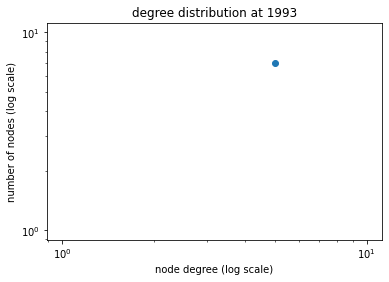

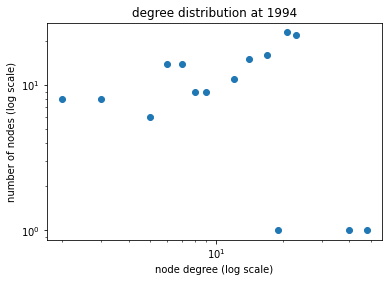

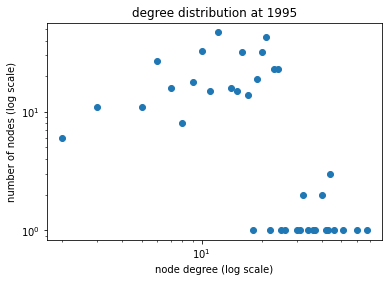

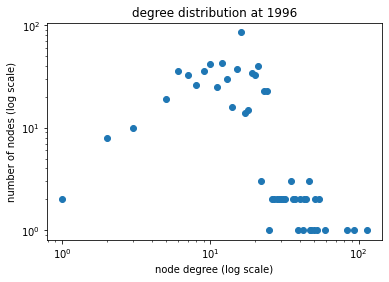

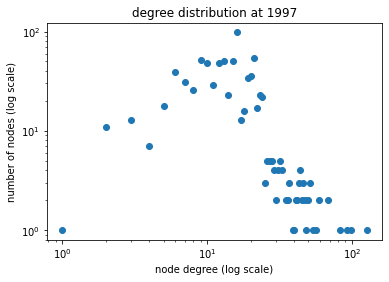

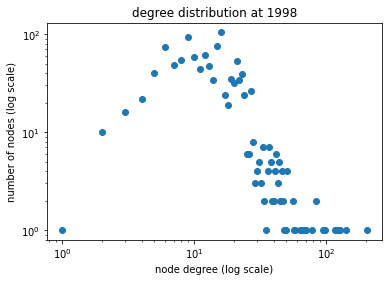

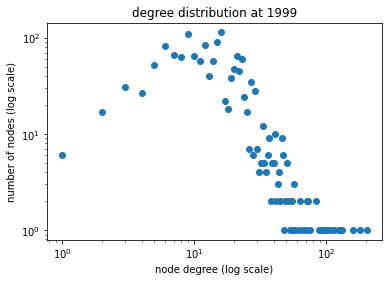

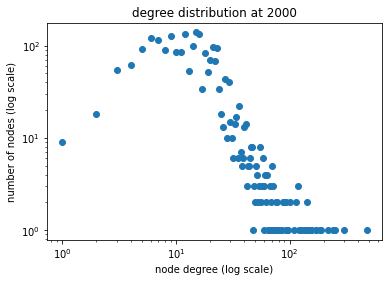

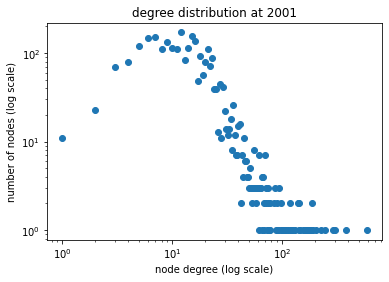

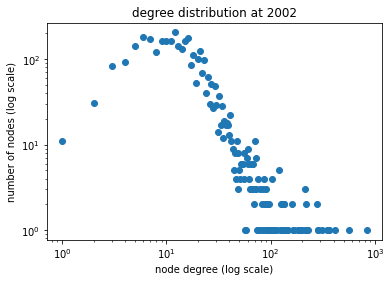

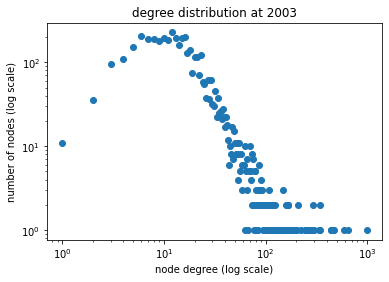

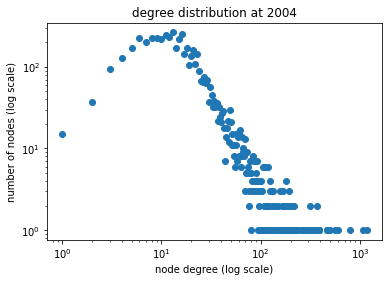

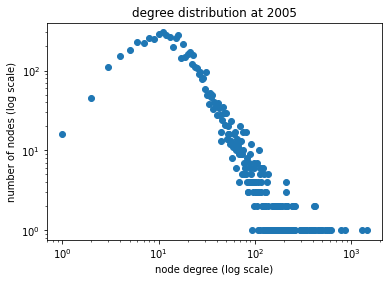

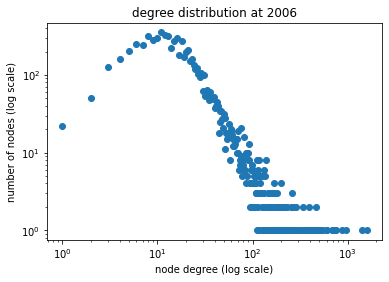

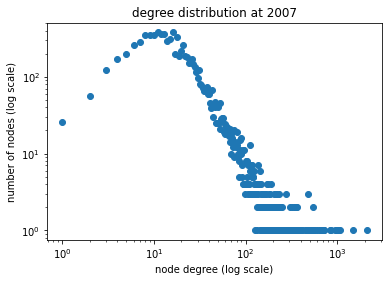

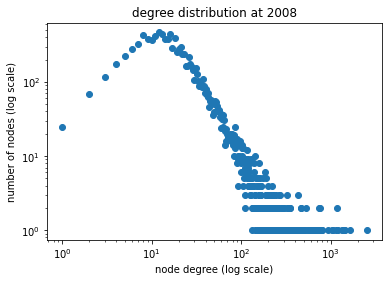

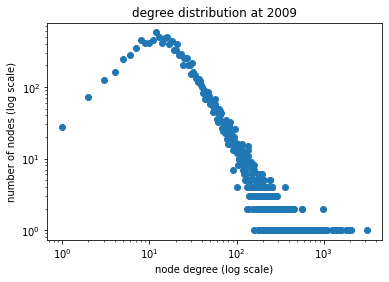

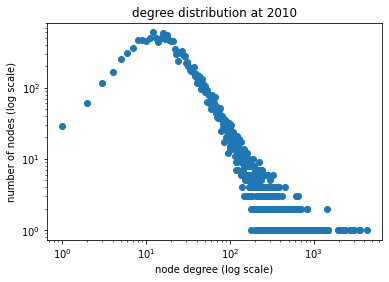

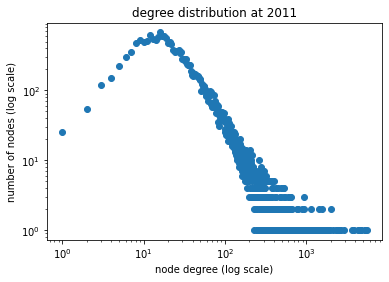

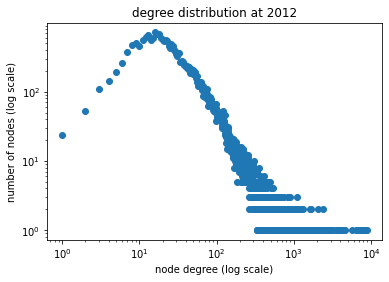

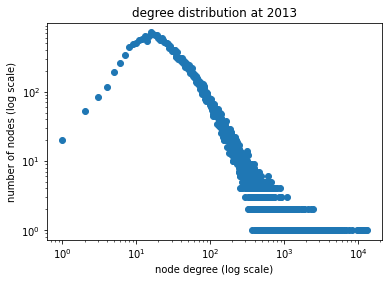

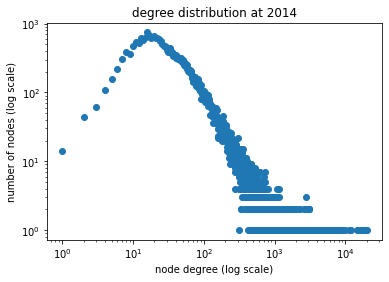

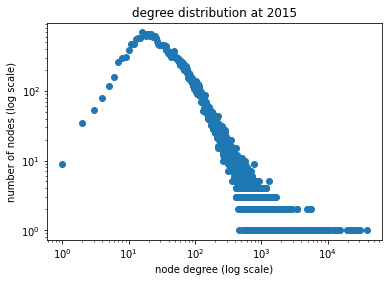

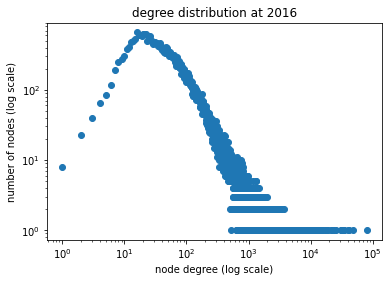

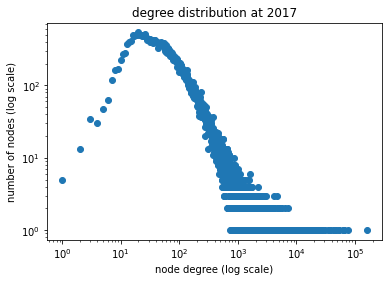

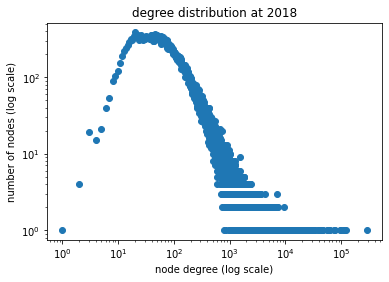

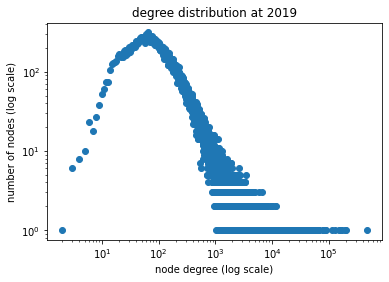

In [ ]:
for yy in yrs:
  edges_small = filter_by_year(edges, before=yy)
  degree_sequence = np.array(get_sparse_from_edges(edges_small).sum(axis=0)).flatten()
  print('total', sum(degree_sequence)/2, 'edges')
  print('max degree', degree_sequence.max(), concepts.loc[degree_sequence == degree_sequence.max()].values.flatten())
  print('min degree', degree_sequence.min())
  print('mean degree', degree_sequence.mean())
  hist, bin_edges = np.histogram(degree_sequence, bins=np.arange(degree_sequence.min(), degree_sequence.max()+1))
  bin_edges = bin_edges[1:-1]
  hist = hist[1:]
  bin_edges = bin_edges[hist != 0]
  hist = hist[hist != 0]
  plt.figure()
  plt.scatter(bin_edges, hist)
  plt.loglog()
  plt.xlabel('node degree (log scale)')
  plt.ylabel('number of nodes (log scale)')
  plt.title('degree distribution at '+str(yy))
  plt.savefig(os.path.join(DRIVE_PATH, '20220203', 'degree_hist', str(yy)+'.jpg'))
  #plt.show()

In [ ]:
import glob
from PIL import Image

frames = [Image.open(image) for image in glob.glob(os.path.join(DRIVE_PATH, '20220203', 'degree_hist', '*.jpg'))]
frame_one = frames[0]
frame_one.save(os.path.join(DRIVE_PATH, '20220203', 'degree_hist', "node_degree_loglog.gif"), format="GIF", append_images=frames,
            save_all=True, duration=500, loop=0)

## Connected components

In [ ]:
ccs = []

for yy in yrs:
  edges_small = filter_by_year(edges, before=yy)
  G = nx.from_pandas_edgelist(edges_small, source='node1', target='node2')
  G.add_nodes_from(range(NUM_OF_VERTICES))
  cc = [len(c) for c in nx.connected_components(G)]
  print(max(cc), sum([1 for c in cc if c==1]))
  ccs.append(cc)

7 64712
49 64561
353 64288
632 64041
828 63880
1146 63533
1467 63194
2281 62349
2733 61898
3486 61164
4285 60384
5353 59325
6435 58249
7507 57195
9125 55573
11228 53478
14036 50673
17604 47107
21914 42801
27256 37459
32512 32207
37499 27220
43412 21307
49920 14799
55978 8741
60771 3948
63472 1247


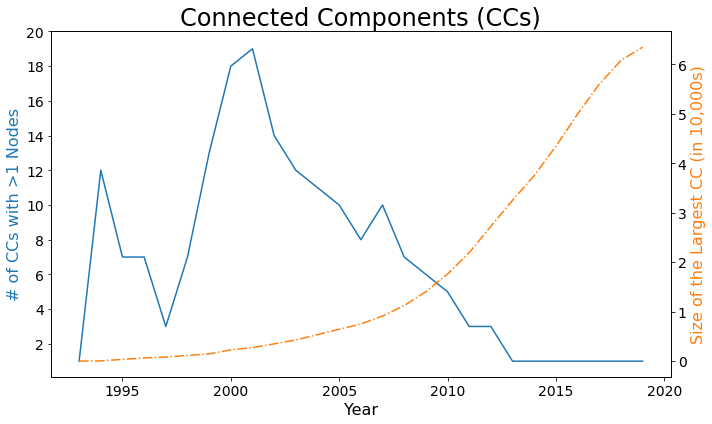

In [ ]:
fig, ax1 = plt.subplots(figsize=(10, 6))

ax2 = ax1.twinx()
ax1.plot(yrs, [sum(np.array(cc)>1) for cc in ccs])
ax2.plot(yrs, [max(cc)/10000 for cc in ccs], '-.', color='tab:orange')

ax1.set_xlabel('Year', fontsize=16)

ax1.set_ylabel('# of CCs with >1 Nodes', fontsize=16, color='tab:blue')
ax1.set_yticks(range(2,21,2))
ax1.set_yticklabels(range(2,21,2), fontsize=14)

ax2.set_ylabel('Size of the Largest CC (in 10,000s)', fontsize=16, color='tab:orange')

ax1.tick_params(axis='both', which='major', labelsize=14)
ax2.tick_params(axis='both', which='major', labelsize=14)

plt.title('Connected Components (CCs)', fontsize=24)

plt.tight_layout()
plt.savefig(os.path.join(DRIVE_PATH, '20220203', 'cc_num.pdf'), dpi=300, pad_inches=0)
plt.show()


In [ ]:
for i in range(len(yrs)):
  tmp = np.array(ccs[i])
  print(yrs[i],tmp[tmp >1])

1993 [7]
1994 [ 7 49  6  3  7  3  9 29  4 22  4 15]
1995 [ 13 353   4  38   4   6  13]
1996 [632   4   6  13  14   2   7]
1997 [828   4   7]
1998 [1146    4    6    6    8    5   11]
1999 [1467    4    6    8    5    4    4    4    4    6    8    2    3]
2000 [2281    4    8    5    4    7    4    4    6    8    2    4    4    2
   15    5    4    3]
2001 [2733    4    8    5    4    7    4    4    8    2    4    4    2   15
    5    4    3    2    3]
2002 [3486    4    8    4    7    4    2    4    4   15    5    2    3    7]
2003 [4285    4    8    7    4    2    4    2    3    7    6    3]
2004 [5353    4    7    4    4    2    3    6    7    2    2]
2005 [6435    4    7    4    2    7    2    2    3    4]
2006 [7507    4    2    2    2    3    2    2]
2007 [9125    4    2    2    2    3    2    2    2    2]
2008 [11228     2     2     3     2     2     2]
2009 [14036     2     2     2     2     2]
2010 [17604     2     2     2     2]
2011 [21914     2     2]
2012 [27256     2     2

In [ ]:
yy=2000
edges_small = filter_by_year(edges, before=yy)
G = nx.from_pandas_edgelist(edges_small, source='node1', target='node2')
G.add_nodes_from(range(NUM_OF_VERTICES))
cc_2001s = nx.connected_components(G)
for c in cc_2001s:
  if (len(c) > 1) and (len(c) < 20):
    print(c)
    print(concepts.loc[c].values.flatten())
    print()

{35541.0, 34233.0, 59605.0, 37151.0}
['reasonable time' 'design process' 'natural case' 'natural class']

{56546.0, 44006.0, 34221.0, 34356.0, 45781.0, 38230.0, 39833.0, 50751.0}
['multiscale transform' 'wavelet transforms' 'central idea'
 'wavelet transform' 'shift invariant' 'filter bank' 'linear filter'
 'shift invariance']

{33476.0, 34052.0, 53968.0, 38227.0, 55737.0}
['general theory' 'image transformation' 'abstract form'
 'normalization method' 'image normalization']

{33712.0, 33601.0, 32453.0, 43031.0}
['information processing' 'function space' 'metric space' 'natural metric']

{51943.0, 55758.0, 34991.0, 32149.0, 37462.0, 59996.0, 55743.0}
['brightness change' 'similarity transformation' 'template matching'
 'local feature' 'invariant representation' 'planar curve'
 'differential invariant']

{43032.0, 50456.0, 49642.0, 32191.0}
['complex phenomenon' 'knowledge structure' 'edge structure' 'ai system']

{34761.0, 59642.0, 55741.0, 31927.0}
['statistical estimation' 'em framew

In [ ]:
yy=2003
edges_small = filter_by_year(edges, before=yy)
G = nx.from_pandas_edgelist(edges_small, source='node1', target='node2')
G.add_nodes_from(range(NUM_OF_VERTICES))
cc_2001s = nx.connected_components(G)
for c in cc_2001s:
  if (len(c) > 1) and (len(c) < 20):
    print(c)
    print(concepts.loc[c].values.flatten())
    print()

{35541.0, 34233.0, 59605.0, 37151.0}
['reasonable time' 'design process' 'natural case' 'natural class']

{56546.0, 44006.0, 34221.0, 34356.0, 45781.0, 38230.0, 39833.0, 50751.0}
['multiscale transform' 'wavelet transforms' 'central idea'
 'wavelet transform' 'shift invariant' 'filter bank' 'linear filter'
 'shift invariance']

{51943.0, 55758.0, 34991.0, 32149.0, 37462.0, 59996.0, 55743.0}
['brightness change' 'similarity transformation' 'template matching'
 'local feature' 'invariant representation' 'planar curve'
 'differential invariant']

{34761.0, 59642.0, 55741.0, 31927.0}
['statistical estimation' 'em framework' 'automatic induction'
 'learned representation']

{33384.0, 41404.0}
['several type' 'several level']

{43817.0, 44818.0, 35652.0, 40935.0}
['linear nature' 'computer code' 'parallel algorithm' 'code generation']

{52848.0, 63807.0}
['representation enables' 'performance monitoring']

{34384.0, 50507.0, 59727.0}
['computational effort' 'usual assumption' 'consider appro

In [ ]:
yy=2006
edges_small = filter_by_year(edges, before=yy)
G = nx.from_pandas_edgelist(edges_small, source='node1', target='node2')
G.add_nodes_from(range(NUM_OF_VERTICES))
cc_2001s = nx.connected_components(G)
for c in cc_2001s:
  if (len(c) > 1) and (len(c) < 20):
    print(c)
    print(concepts.loc[c].values.flatten())
    print()

{43817.0, 44818.0, 35652.0, 40935.0}
['linear nature' 'computer code' 'parallel algorithm' 'code generation']

{52848.0, 63807.0}
['representation enables' 'performance monitoring']

{7969.0, 55826.0}
['chinese room argument' 'system could']

{38458.0, 59794.0}
['shape descriptor' 'open space']

{41225.0, 52974.0, 13334.0}
['positive semidefinite' 'generating function'
 'positive semidefinite kernel']

{46306.0, 43095.0}
['application context' 'evaluation procedure']

{48721.0, 50618.0}
['formal logic' 'individual parameter']



## Other useful functions

In [ ]:
kg_small = filter_by_year(edges, before=2005)

In [ ]:
#topic = 'knowledge graph'
#topic = 'crime'
topic = ['multiscale transform', 'wavelet transforms', 'central idea',
 'wavelet transform', 'shift invariant', 'filter bank', 'linear filter',
 'shift invariance']
if type(topic)==list:
  topic = '|'.join(topic)
kg = concepts[concepts['concept'].str.contains(topic)]
print(len(kg), 'nodes about', topic)
kg

28 nodes about multiscale transform|wavelet transforms|central idea|wavelet transform|shift invariant|filter bank|linear filter|shift invariance


,concept
801,discrete wavelet transform
4835,non linear filter
5579,discrete wavelet transforms
5933,continuous wavelet transform
6612,dual tree complex wavelet transform
8112,haar wavelet transform
10159,gabor filter bank
10838,shift invariant kernel
13766,gabor wavelet transformation
14432,inverse wavelet transform


In [ ]:
#nodes = [31910]
#nodes = kg.index
nodes = [51943, 55758, 34991, 32149, 37462, 59996, 55743]
#nodes = [43968, 31844, 35558, 36845, 32881, 58385, 39323]
edges_small = filter_by_year(edges, before=2006)

kg_edges = edges_small[edges_small['node1'].isin(nodes) | edges_small['node2'].isin(nodes)]
map_concepts(kg_edges)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


,node1,node2,timestamp,concept1,concept2
10454,55743.0,59996.0,3363.0,differential invariant,planar curve
12767,32149.0,51943.0,3524.0,local feature,brightness change
12768,32149.0,55743.0,3524.0,local feature,differential invariant
12769,51943.0,55743.0,3524.0,brightness change,differential invariant
16804,32149.0,34991.0,3737.0,local feature,template matching
16805,32149.0,37462.0,3737.0,local feature,invariant representation
16806,32149.0,55743.0,3737.0,local feature,differential invariant
16807,32149.0,55758.0,3737.0,local feature,similarity transformation
16808,34991.0,37462.0,3737.0,template matching,invariant representation
16809,34991.0,55743.0,3737.0,template matching,differential invariant


subgraph with nodes: [51943, 55758, 34991, 32149, 37462, 59996, 55743]
6836 nodes
14392 edges


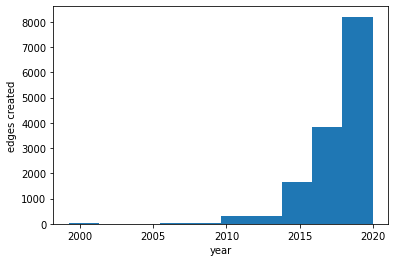

In [ ]:
onehop_nodes = set(list(kg_edges['node1'].unique()) + list(kg_edges['node2'].unique()))
print('subgraph with nodes:', nodes)
print(len(onehop_nodes), 'nodes')
print(len(kg_edges), 'edges')

plt.hist(kg_edges['timestamp']/365 + 1990)
plt.xlabel('year')
plt.ylabel('edges created')
plt.show()

In [ ]:
kg_small = filter_by_year(kg_edges, before=2016)
map_concepts(kg_small)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


,node1,node2,timestamp,concept1,concept2
2430764,1893.0,31910.0,9191.0,large knowledge graph,knowledge graph
2430783,8186.0,31910.0,9191.0,statistical relational model,knowledge graph
2430801,8409.0,31910.0,9191.0,latent feature model,knowledge graph
2430818,31762.0,31910.0,9191.0,neural network,knowledge graph
2430834,31763.0,31910.0,9191.0,machine learning,knowledge graph
...,...,...,...,...,...
4944128,31910.0,43025.0,9844.0,knowledge graph,acquire knowledge
4944129,31910.0,46343.0,9844.0,knowledge graph,vision algorithm
4944130,31910.0,47424.0,9844.0,knowledge graph,structured prior
4944131,31910.0,52977.0,9844.0,knowledge graph,label class


In [ ]:
kg_small = filter_by_year(kg_edges, after=2019)
map_concepts(kg_small)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


,node1,node2,timestamp,concept1,concept2
12011751,1.0,31910.0,10611.0,convolutional neural network,knowledge graph
12011771,73.0,31910.0,10611.0,zero shot learning,knowledge graph
12011790,788.0,31910.0,10611.0,transfer learning method,knowledge graph
12011808,7557.0,31910.0,10611.0,human understandable explanation,knowledge graph
12011825,31762.0,31910.0,10611.0,neural network,knowledge graph
...,...,...,...,...,...
17892256,31910.0,42185.0,10954.0,knowledge graph,clinical dataset
17892257,31910.0,42717.0,10954.0,knowledge graph,clinical datasets
17892258,31910.0,47635.0,10954.0,knowledge graph,representation model
17892259,31910.0,51187.0,10954.0,knowledge graph,spearman correlation


In [ ]:
kg_small = filter_by_year(kg_edges, before=2019, after=2018)
map_concepts(kg_small)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


,node1,node2,timestamp,concept1,concept2
7720005,812.0,31910.0,10237.0,question answering system,knowledge graph
7720020,905.0,31910.0,10237.0,travelling salesman problem,knowledge graph
7720034,5087.0,31910.0,10237.0,natural language input,knowledge graph
7720047,21330.0,31910.0,10237.0,generalised travelling salesman problem,knowledge graph
7720059,26500.0,31910.0,10237.0,underlying knowledge graph,knowledge graph
...,...,...,...,...,...
17892256,31910.0,42185.0,10954.0,knowledge graph,clinical dataset
17892257,31910.0,42717.0,10954.0,knowledge graph,clinical datasets
17892258,31910.0,47635.0,10954.0,knowledge graph,representation model
17892259,31910.0,51187.0,10954.0,knowledge graph,spearman correlation


In [ ]:
# kg_small = kg_small.drop(['timestamp'], axis=1)
# kg_small = kg_small.rename({'node1':'source', 'node2':'target'}, axis=1)
# kg_small
